In [29]:
import pandas as pd
import warnings
from lifelines import CoxPHFitter, CoxTimeVaryingFitter
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
warnings.filterwarnings("ignore")

# Import des données

In [20]:
df = pd.read_csv('../data/base_modelis_pass_det.csv',sep = ';')

In [21]:
df['date_entree_defaut'] = pd.to_datetime(df['date_entree_defaut'], format='%d/%m/%y')
df['date_sortie_defaut'] = pd.to_datetime(df['date_sortie_defaut'], format='%d/%m/%y', errors='coerce')
df['arrete'] = pd.to_datetime(df['arrete'], format='%d/%m/%y')
df['DT_MEP_OPE'] = pd.to_datetime(df['DT_MEP_OPE'], format='%d%b%Y:%H:%M:%S.%f')
df['dt_arr_last_enc_ope'] = pd.to_datetime(df['dt_arr_last_enc_ope'], errors='coerce')
df['dt_arr_1st_enc_ope'] = pd.to_datetime(df['dt_arr_1st_enc_ope'], errors='coerce')
df['dtHJD_prov'] = pd.to_datetime(df['dtHJD_prov'], errors='coerce')
df['dtHJD_def'] = pd.to_datetime(df['dtHJD_def'], errors='coerce')

In [22]:
for column in df.columns :
    if df[column].isna().sum()/df.shape[0] > 0.5 : 
        df.drop(columns = [column], inplace = True)

In [23]:
df.drop(columns = ["CD_POST_BIEN_PFI"], inplace = True)

In [24]:
var_to_categorize = [
    "FL_REL_NON_ANNULE",
    "FL_ETR",
    "CD_ETAT_CIVIL",
    "CD_DNE_CHR_LGD_SAIN",
    "fl_prise_de_gar",
    "fl_fam_vam",
    "fam_ETH",
    "fam_ENQ",
    "fam_exp",
    "fam_hyp",
    "fam_sim",
    "fam_AEP",
    "dat_dec_echec",
    "solution",
    "fam_PCD",
    "CD_MTF_ENE_CTX",
    "niv_gravite_mtf_dne",
    "niv_gravite_mtf_dfs",
    "no_pass_def",
    "fl_def_ss_pass_CTX",
    "fl_prt_Conso",
    "fl_fonc",
    "AMI",
    "EXE",
    "PTG"
]
for var in var_to_categorize : 
    df[var] = df[var].astype("object")

In [25]:
cols_numeriques = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
cols_categorielles = df.select_dtypes(include=['object']).columns.to_list()
cols_categorielles.remove("cd_op")

for col in cols_numeriques:
    df[col].fillna(df[col].mean(), inplace=True)

for col in cols_categorielles:
    df[col].fillna(df[col].mode()[0], inplace=True)

In [26]:
def encode_columns(df):
    encoders = {}
    for column in cols_categorielles:
        unique_values = df[column].nunique()
        if unique_values <= 3:
            # Appliquer OneHotEncoder
            encoder = OneHotEncoder(sparse=False)
            encoded = encoder.fit_transform(df[[column]])
            encoders[column] = encoder

            # Remplacer la colonne originale par de nouvelles colonnes pour chaque catégorie
            for i, category in enumerate(encoder.categories_[0]):
                df[str(column) + '_' + str(category)] = encoded[:, i]
            df.drop(column, axis=1, inplace=True)
        else:
            # Appliquer LabelEncoder
            encoder = LabelEncoder()
            df[column] = encoder.fit_transform(df[column])
            encoders[column] = encoder
    return df, encoders

encoded_df, encoders = encode_columns(df)

In [27]:
from scipy.stats import pointbiserialr


def calculate_pointbiserial_corr(df, binary_var):
    corr_dict = {}
    for col in df.columns:
        if col != binary_var:
            corr, p_value = pointbiserialr(df[binary_var], df[col])
            corr_dict[col] = corr
    return corr_dict

# Calcul de la corrélation point-bisériale
corr_dict = calculate_pointbiserial_corr(encoded_df, 'fl_pass_DET')

# Filtrer les variables avec une corrélation > 0.30
selected_variables = {k: v for k, v in corr_dict.items() if abs(v) > 0.05}

selected_variables.keys()

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U10')) -> None

In [28]:
df_validation = df[df['arrete']>"2020-12-30"]
df_train = df[df['arrete']<"2020-12-30"]

# Préparation des données

In [30]:
data_haz = df_train.copy()

In [31]:
data_haz['start'] = 0
data_haz['stop'] = data_haz['arrete'] - data_haz['date_entree_defaut']
data_haz['stop'] = data_haz['stop'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [32]:
data_haz['stop'] = data_haz['stop'].astype('int') / 1000000

In [33]:
data_haz['id'] = data_haz['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [34]:
data_haz.loc[(data_haz['start'] == data_haz['stop']) & (data_haz['start'] == 0) & data_haz[
    'fl_pass_DET'], 'stop'] = 0.5  # car le modele n'accepte pas les individus qui sortent de la survie au moment ou ils y entrent donc on remplace les 0 par 0.5.

In [36]:
data_haz = data_haz.select_dtypes(exclude=["datetime64"])

In [39]:
data_haz.drop(columns = ["cd_op"], inplace = True)

# Modélisation

In [40]:
data_haz

,fl_pass_DET,nb_prt,CD_NAT_EMP1,CD_NAT_EMP2,ANC_BANC_MAX_PFI,CD_DEST_PFI,CD_NATUR_OP_PFI,MT_PATRIM_MOB,MT_CHA_HORS_OPE_PFI,NB_CHARGE_HORS_OPE_PFI,...,fl_fonc_1,AMI_0.0,AMI_1.0,EXE_0.0,EXE_1.0,PTG_0.0,PTG_1.0,start,stop,id
0,0,1,3,2,83.291914,5,16,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0,15.0,860708600
1,0,1,3,2,83.291914,5,16,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0,43.0,860708600
2,0,1,3,2,83.291914,5,16,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0,74.0,860708600
3,0,1,3,2,83.291914,5,16,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0,104.0,860708600
4,0,1,3,2,83.291914,5,16,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0,135.0,860708600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327989,0,1,3,2,40.000000,0,16,150047.0,40006.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0,9.0,200618962
327990,0,1,3,2,40.000000,0,16,150047.0,40006.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,39.0,200618962
328215,0,1,3,2,9.000000,3,10,82675.0,47784.0,2.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0,11.0,200807648
328216,0,1,3,2,9.000000,3,10,82675.0,47784.0,2.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0,42.0,200807648


In [41]:
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(data_haz, id_col="id", event_col="fl_pass_DET", stop_col="stop", show_progress=True)

Iteration 1: norm_delta = 8.51e-01, step_size = 0.9500, log_lik = -55589.29814, newton_decrement = 1.38e+04, seconds_since_start = 72.7
Iteration 2: norm_delta = 2.65e+01, step_size = 0.9500, log_lik = -366474.23453, newton_decrement = 8.63e+06, seconds_since_start = 149.9
Iteration 3: norm_delta = 2.59e+00, step_size = 0.0950, log_lik = -8272443.26811, newton_decrement = 8.27e+06, seconds_since_start = 223.2
Iteration 4: norm_delta = 2.99e+00, step_size = 0.1210, log_lik = -6775746.09560, newton_decrement = 6.77e+06, seconds_since_start = 295.5
Iteration 5: norm_delta = 3.34e+00, step_size = 0.1542, log_lik = -5236010.06967, newton_decrement = 5.23e+06, seconds_since_start = 369.3
Iteration 6: norm_delta = 3.60e+00, step_size = 0.1964, log_lik = -3748211.03542, newton_decrement = 3.74e+06, seconds_since_start = 443.7
Iteration 7: norm_delta = 3.68e+00, step_size = 0.2503, log_lik = -2424695.32580, newton_decrement = 2.41e+06, seconds_since_start = 517.2
Iteration 8: norm_delta = 3.50e

<lifelines.CoxTimeVaryingFitter: fitted with 221971 periods, 17815 subjects, 5006 events>

In [42]:
ctv.print_summary()

<lifelines.CoxTimeVaryingFitter: fitted with 221971 periods, 17815 subjects, 5006 events>
         event col = 'fl_pass_DET'
         penalizer = 0.1
number of subjects = 17815
 number of periods = 221971
  number of events = 5006
partial log-likelihood = -253545.91
  time fit was run = 2024-01-07 10:14:18 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
nb_prt                    0.02       1.02       0.01            -0.00             0.05                 1.00                 1.05
CD_NAT_EMP1              -0.05       0.95       0.02            -0.08            -0.02                 0.92                 0.98
CD_NAT_EMP2              -0.06       0.94       0.02            -0.10            -0.02                 0.90                 0.98
ANC_BANC_MAX_PFI          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CD_DEST_PFI               0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
CD_NATUR_OP_PFI          -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
MT_PATRIM_MOB             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MT_CHA_HORS_OPE_PFI      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
NB_CHARGE_HORS_OPE_PFI   -0.02       0.98       0.00            -0.02            -0.01                 0.98                 0.99
MT_PATRIM_NET            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MT_REV_PFI               -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
NB_DUR_PFI                0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
TX_APPOR                  0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02
MT_CHA_CSM_REV            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MT_CHA_IMP               -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MT_CHA_PIP               -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MT_CHA_PIV               -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
CD_ETAT_CIVIL             0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
CD_CSP_EMP1               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CD_CSP_EMP2               0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CD_SITFAM_EMP1            0.01       1.01       0.00            -0.00             0.01                 1.00                 1.01
CD_SITFAM_EMP2            0.00       1.00       0.01            -0.01             0.02                 0.99                 1.02
NB_RP_HOP                -0.03       0.97       0.01            -0.06             0.00                 0.94                 1.00
NB_RS_HOP                 0.04       1.04       0.02            -0.00             0.09                 1.00                 1.09
NB_LO_HOP                -0.02       0.99       0.01            -0.03            -0.00                 0.97                 1.00
cum_dec                   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
cum_rec                  -0.00       1.00       0.00            -0.00  

<Axes: xlabel='log(HR) (95% CI)'>

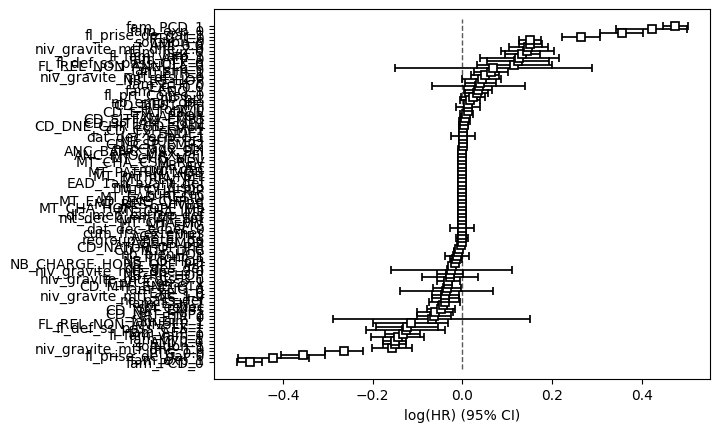

In [43]:
ctv.plot()